In [3]:
import argparse
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
import torch
import gc
import os, json, pickle
from types import SimpleNamespace
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib


In [1]:
from Methods.BiScope.biscope_utils import *

In [2]:
# from utils
from Code_preprocessing.code_cleaner import comment_remover as CR

# MODEL_ZOO and detect_single_sample(...) are already defined/imported from Methods.BiScope.biscope_util

def data_generation(
    *,
    out_dir: str,
    detect_model: str,
    summary_model: str = "none",
    sample_clip: int = 2000,
    split_ratio: float = 0.1,
    n_segments: int = 10,
    device: str | None = None,
    human_code_dir : str,
    LLM_code_dir : str,
):
    """
    Generate loss-based features for the Code task using local datasets only (paraphrased LLM data).

    Parameters
    ----------
    out_dir : str
        Output directory where feature pickles will be saved.
    detect_model : str
        Key in MODEL_ZOO for the surrogate detection model, e.g. "llama2-7b".
    summary_model : str, default="none"
        Guidance/summary model key (MODEL_ZOO) or "none" to disable summaries.
    sample_clip : int, default=2000
        Max token length for samples (truncation).
    split_ratio : float, default=0.1
        Ratio for Segment-1 vs Segment-2 inside detect_single_sample (if implemented there).
    n_segments : int, default=10
        Number of disjoint segments to compute stats on (if implemented there).
    device : str | None, default=None
        "cuda", "cpu", or None to auto-select.

    Returns
    -------
    str
        The output directory (out_dir).
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    os.makedirs(out_dir, exist_ok=True)



    train_dir = os.path.join(out_dir, "train")
    test_dir  = os.path.join(out_dir, "test")


    # (1) SUMMARY: Load optional summary model
    if summary_model in MODEL_ZOO:
        summary_m = AutoModelForCausalLM.from_pretrained(
            MODEL_ZOO[summary_model],
            torch_dtype=torch.float16 if device.startswith("cuda") else None,
            device_map="auto" if device.startswith("cuda") else None
        ).eval()
        summary_tok = AutoTokenizer.from_pretrained(MODEL_ZOO[summary_model], padding_side="left")
        summary_tok.pad_token = summary_tok.eos_token
    else:
        summary_m, summary_tok = None, None
        print("No summary mode")




    # (2) DETECTION MODEL (logits): Load detection model (required)
    if detect_model not in MODEL_ZOO:
        raise ValueError(f"Unknown detection model key: {detect_model}. Must be one of: {list(MODEL_ZOO)}")
    det_m = AutoModelForCausalLM.from_pretrained(
        MODEL_ZOO[detect_model],
        torch_dtype=torch.float16 if device.startswith("cuda") else None,
        device_map="auto" if device.startswith("cuda") else None
    ).eval()
    det_tok = AutoTokenizer.from_pretrained(MODEL_ZOO[detect_model], padding_side="left")
    det_tok.pad_token = det_tok.eos_token




    # (3) Load local data
    # (3.1) Humans (always non-paraphrased) 
    with open(human_code_dir, "r", encoding="utf-8") as f:
        human_raw = json.load(f)
    # In the original repo, each item is [solution, solution_pt2] → concatenate
    human_data = []
    for row in human_raw:
        if len(row) == 2:
            human_data.append(row[0] + row[1])
        elif len(row) == 1:
            human_data.append(row[0])
        elif isinstance(row, str):
            human_data.append(row)
        else:
            raise ValueError(row)
    
    del human_raw




    # (3.2) LLM
    if not os.path.exists(LLM_code_dir):
        raise FileNotFoundError(f"LLM file not found: {LLM_code_dir}")
    with open(LLM_code_dir, "r" , encoding="utf-8") as f:
        gpt_raw = json.load(f)

    gpt_data = []
    for row in gpt_raw:
        if len(row) == 2:
            gpt_data.append(row[0] + row[1])
        elif len(row) == 1:
            gpt_data.append(row[0])
        elif isinstance(row, str):
            gpt_data.append(row)
        else:
            raise ValueError(row)
        
    
    del gpt_raw


    
    # COMMENT REMOVER _____________________
    new_human_data = []
    new_gpt_data = []
    for row_h, row_L in zip(human_data, gpt_data):
        new_human_data.append(CR(row_h))
        new_gpt_data.append(CR(row_L))
    
    del human_data
    del gpt_data



    #____________________________




    # (4) Build a tiny namespace so detect_single_sample can read the knobs it expects
    #     (summary_model, sample_clip, split_ratio, n_segments)
    args_like = SimpleNamespace(
        summary_model=summary_model,
        sample_clip=sample_clip,
        split_ratio=split_ratio,
        n_segments=n_segments,
    )
    #############

    print("STARTING Features Extract...\n\n\n")
    

    
    # (5) Extract & save features
    # Path of the dataset
    human_feat_path = os.path.join(out_dir, "human_features.pkl")
    if not os.path.isfile(human_feat_path):
        human_features = [
            detect_single_sample(args_like, det_m, det_tok, summary_m, summary_tok, text, device=device)
            for text in tqdm(new_human_data, desc="Human (Code)")
        ]
        with open(human_feat_path, "wb") as f:
            pickle.dump(human_features, f)


    gpt_feat_path = os.path.join(out_dir, "LLM_features.pkl")
    if not os.path.isfile(gpt_feat_path):
        gpt_features = [
            detect_single_sample(args_like, det_m, det_tok, summary_m, summary_tok, text, device=device)
            for text in tqdm(new_gpt_data, desc="LLM Code")
        ]
        with open(gpt_feat_path, "wb") as f:
            pickle.dump(gpt_features, f)

    
    # DEALLOCATION
    del det_m
    del det_tok
    gc.collect()

    # se sei su GPU, libera la cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    return human_feat_path, gpt_feat_path

## Train

In [4]:
import joblib


def train(
        *, 
        detect_model: str, 
        seed: int=42, sample_clip: int=2000, summary_model: str="none",
        split_ratio: float = 0.1, n_segments: int = 10,
        output_path: str,
        train_dataset_LLM_path: str = "./Methods/BiScope/Code/gpt-3.5-turbo.json",
        train_dataset_human_path:str = "./Methods/BiScope/Code/human.json"):
    '''
    detect_model : str, required
        Key of the surrogate (open-source) model used to extract logits/FCE/BCE.
        Must be a valid key in MODEL_ZOO (e.g., "llama2-7b", "mistral-7b", ...).
    test_dataset : str, required
        Test dataset name with the same format as `val_dataset`.
    seed : int, default=42
        Random seed for reproducibility. Applied to Python, NumPy, and PyTorch (CPU/GPU).
    sample_clip : int, default=2000
        Maximum token length for each sample; texts longer than this are truncated.
    summary_model : str, default="none"
        Model used to generate the summary/guidance for the prompt, or "none" to disable summaries.
        Examples: "none", "gpt-4o-mini", or a key from MODEL_ZOO (e.g., "llama2-7b").
    split_ratio : int, default=0.1 
        .
    n_segments : int, default=10
        .
    '''
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"device: {device}")

    # Set seeds.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    ####
    
    
    # Create a base output directory that includes both train and test dataset strings.
    os.makedirs(output_path, exist_ok=True)
    
    
    # Generate features for the training dataset.
    print("Generating train features...")

    torch.set_grad_enabled(False)
    human_feat_path, gpt_feat_path = data_generation(out_dir=output_path, 
                    detect_model=detect_model, 
                    summary_model=summary_model,
                    sample_clip=sample_clip, 
                    split_ratio=split_ratio,
                    n_segments=n_segments,
                    device=device,
                    human_code_dir = train_dataset_human_path,
                    LLM_code_dir = train_dataset_LLM_path,
                    )
    torch.set_grad_enabled(True)
    
    # Load train features.
    with open(human_feat_path, 'rb') as f:
        train_human = np.array(pickle.load(f))
    with open(gpt_feat_path, 'rb') as f:
        train_gpt = np.array(pickle.load(f))
    

    
    # CLASSIFICTION TRAINING
    print("TRAINING...")
    train_feats = np.concatenate([train_human, train_gpt], axis=0)
    train_labels = np.concatenate([np.zeros(len(train_human)), np.ones(len(train_gpt))], axis=0)
    clf = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf.fit(train_feats, train_labels)



    # SAVE MODEL
    metadata = {
        "detect_model": detect_model,
        "summary_model": summary_model,
        "sample_clip": sample_clip,
        "split_ratio": split_ratio,
        "n_segments": n_segments,
        "task": "Code",               # es. "Code"
        "feature_schema": "10x(FCE+BCE)*4stats",  # ?
        "trained_on": {
            "human_n": int(len(train_human)),
            "gpt_n": int(len(train_gpt)),
        },
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    }

    bundle = {"clf": clf, "metadata": metadata}

    model_path = os.path.join(output_path, f"biscope_rf.joblib")
    joblib.dump(bundle, model_path)
    print("Saved:", model_path)


    return model_path

        



In [ ]:
model_path =train(detect_model="mistral-7b", 
                    seed=42, sample_clip=2000, summary_model="none", 
                    split_ratio = 0.1, n_segments = 10,
                    output_path = "./Output/train",
                    train_dataset_LLM_path = "./Methods/BiScope/Code/gpt-3.5-turbo.json",
                    train_dataset_human_path = "./Methods/BiScope/Code/human.json"
                    )

device: cuda
Generating train features...
No summary mode


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


STARTING Features Extract...





LLM Code: 100%|██████████| 164/164 [01:11<00:00,  2.30it/s]


TRAINING...
Saved: ./Output/BiScope/train\biscope_rf.joblib


## Test

### our dataset

In [ ]:
import pandas as pd
import json

AIG_human_path = "./Methods/BiScope/MyData/AIGCodeSethuman.json"
AIG_llm_path = "./Methods/BiScope/MyData/AIGCodeSetllm.json"

AIG = pd.read_csv("./Dataset/AIGCodeSet.csv")

# colonna da tenere
CODE_CONLUMN = "cleared_code"       # <-- la feature che vuoi salvare
SPLIT = "LLM"        # <-- la colonna che decide dove va il sample
target = "Human"              # <-- valore discriminante

# lista dei campioni
dataset_match = AIG[AIG[SPLIT] == target][CODE_CONLUMN].apply(lambda x: [x]).tolist()
dataset_other = AIG[AIG[SPLIT] != target][CODE_CONLUMN].apply(lambda x: [x]).tolist()




# salva i due json
with open(AIG_human_path, "w", encoding="utf-8") as f:
    json.dump(dataset_match, f, ensure_ascii=False, indent=2)

with open(AIG_llm_path, "w", encoding="utf-8") as f:
    json.dump(dataset_other, f, ensure_ascii=False, indent=2)


In [22]:
## TP a FP fissato
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def tpr_curve_at_fpr(y_true, y_score, fpr_grid=None, num_points=201):
    """
    Restituisce la curva TPR@FPR≤x.
    - y_true: etichette binarie (0/1)
    - y_score: punteggi continui del modello
    - fpr_grid: array di FPR target (opzionale). Se None, usa np.linspace(0,1,num_points).
    - num_points: numero di punti se fpr_grid è None.
    Ritorna: (fpr_grid_sorted, tpr_at_grid)
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ##
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")  # baseline random
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    ##

    # ordina per FPR crescente
    order = np.argsort(fpr)
    fpr = fpr[order]
    tpr = tpr[order]

    # TPR massima ottenibile con vincolo FPR ≤ x (frontiera superiore a gradini)
    tpr_cummax = np.maximum.accumulate(tpr)

    if fpr_grid is None:
        fpr_grid = np.linspace(0.0, 1.0, num_points)
    fpr_grid = np.asarray(fpr_grid)
    sort_idx = np.argsort(fpr_grid)
    fpr_grid_sorted = fpr_grid[sort_idx]

    # per ogni x in fpr_grid, prendi l'indice dell'ultimo fpr ≤ x
    idx = np.searchsorted(fpr, fpr_grid_sorted, side="right") - 1
    # se x < fpr[0], metti indice -1 → TPR=0
    tpr_at_grid_sorted = np.where(idx >= 0, tpr_cummax[idx], 0.0)

    # riporta all’ordine originale se necessario
    inv = np.empty_like(sort_idx)
    inv[sort_idx] = np.arange(len(sort_idx))

    fpr_grid, tpr_grid = fpr_grid, tpr_at_grid_sorted[inv]

    plt.plot(fpr_grid, tpr_grid)
    plt.xlabel("FPR massimo consentito")
    plt.ylabel("TPR ottenibile")
    plt.title("TPR @ FPR≤x")
    plt.grid(True)
    plt.show()




### test

In [ ]:
def test(
        *, 
        model_path: str,
        detect_model: str, 
        seed: int=42, sample_clip: int=2000, summary_model: str="none",
        split_ratio: float = 0.1, n_segments: int = 10,
        output_path: str,
        test_dataset_LLM_path: str ,
        test_dataset_human_path: str):
    """

    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"device: {device}")

    # Set seeds.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    ####
    
    
    # Create a base output directory that includes both train and test dataset strings.
    os.makedirs(output_path, exist_ok=True)
    
    
    # Generate features for the training dataset.
    print("Generating train features...")

    torch.set_grad_enabled(False)
    human_feat_path, gpt_feat_path = data_generation(out_dir=output_path, 
                    detect_model=detect_model, 
                    summary_model=summary_model,
                    sample_clip=sample_clip, 
                    split_ratio=split_ratio,
                    n_segments=n_segments,
                    device=device,
                    human_code_dir = train_dataset_human_path,
                    LLM_code_dir = train_dataset_LLM_path,
                    )
    torch.set_grad_enabled(True)



    # Carica feature test
    with open(human_feat_path, 'rb') as f:
        test_human = np.array(pickle.load(f))
    with open(gpt_feat_path, 'rb') as f:
        test_gpt = np.array(pickle.load(f))


    # Carica il modello allenato
    bundle = joblib.load(model_path)
    clf = bundle["clf"]

    # Costruisce X_test e y_test
    X_test = np.concatenate([test_human, test_gpt], axis=0)
    y_test = np.concatenate([np.zeros(len(test_human)), np.ones(len(test_gpt))], axis=0)
    print(f"len human:{len(test_human)} len gpt:{len(test_gpt)}")

    # Predizioni e metriche
    preds = clf.predict(X_test)
    print(len(preds))
    acc = (preds == y_test).mean()
    f1 = f1_score(y_test, preds)

    TP_5 = tpr_curve_at_fpr(y_test, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1: {f1:.4f}")

    # Salva metriche
    with open(os.path.join(output_path, "metrics.txt"), "w") as f:
        f.write(f"acc={acc:.6f}\n")
        f.write(f"f1={f1:.6f}\n")

    return acc, f1, TP_5


device: cuda
Generating train features...
No summary mode


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


STARTING Features Extract...



len human:249 len gpt:249
498


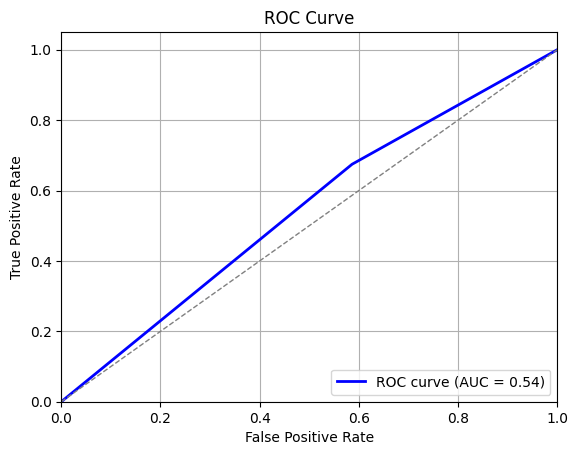

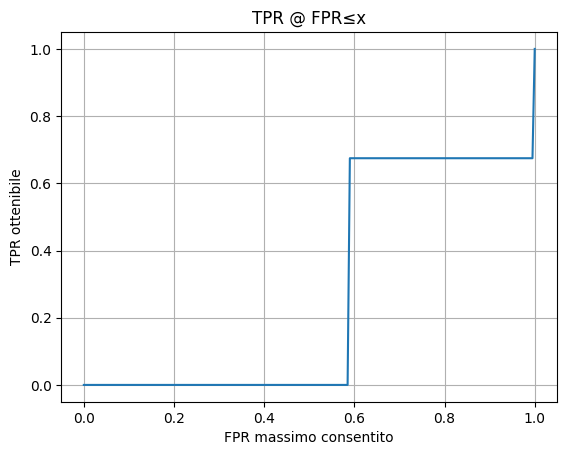

Test Accuracy: 0.5442
Test F1: 0.5968
None


In [ ]:
acc, f1, TP_5 = test(
    model_path = "./Output/train/biscope_rf.joblib",
    detect_model="mistral-7b",
    seed=42,
    sample_clip=2000,
    summary_model="none",
    split_ratio=0.1,
    n_segments=10,
    output_path = "./Output/test",
    test_dataset_LLM_path = AIG_human_path,
    test_dataset_human_path = AIG_llm_path
)

print(TP_5)